In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to create train and validation sets
- Test set has already been created

In [2]:
from IPython.display import display
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load Data

In [3]:
nrows = None
data = pd.read_csv('data/transformed/transformed_data.csv', nrows=nrows)

# order by user id and timestamp
data = data.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

X = data.drop('activity', axis=1)
y = data['activity']

# Split the data into train and validation sets
- Split based on User ID

In [4]:

# unique user id
user_ids = X['user_id'].unique()

# split user ids into train, validation and test
train_ids, test_ids = train_test_split(user_ids, test_size=0.2, random_state=42)

# split train ids into train and validation
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

# split data into train, validation and test
train = data[data['user_id'].isin(train_ids)]
val = data[data['user_id'].isin(val_ids)]
test = data[data['user_id'].isin(test_ids)]

In [5]:
print('Training Set')
print(f'{train.shape[0]} rows')
print(f'{val.shape[0]} rows')
print(f'{test.shape[0]} rows')

Training Set
632284 rows
199298 rows
266622 rows


# Scale and encode data

In [6]:
features = ['x', 'y', 'z']
target = 'activity'

scaler = MinMaxScaler()
encoder = LabelEncoder()

In [7]:
pd.options.mode.chained_assignment = None

train[features] = scaler.fit_transform(train[features])
val[features] = scaler.transform(val[features])
test[features] = scaler.transform(test[features])

train[target] = encoder.fit_transform(train[target])
val[target] = encoder.transform(val[target])
test[target] = encoder.transform(test[target])

# save the scaler and encoder using joblib
joblib.dump(encoder, "models/encoder.pkl")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [8]:
display(train.head())
display(val.head())
display(test.head())

,user_id,activity,timestamp,x,y,z
0,1,5,4991922345000,0.513664,0.766961,0.766961
1,1,5,4991972333000,0.669534,0.682219,0.682219
2,1,5,4992022351000,0.519737,0.636570,0.636570
3,1,5,4992072339000,0.442814,0.620933,0.620933
4,1,5,4992122358000,0.380061,0.602774,0.602774


,user_id,activity,timestamp,x,y,z
128544,6,1,0,0.496204,0.494578,0.494578
128545,6,1,0,0.496204,0.494578,0.494578
128546,6,1,0,0.496204,0.494578,0.494578
128547,6,1,0,0.496204,0.494578,0.494578
128548,6,1,0,0.496204,0.494578,0.494578


,user_id,activity,timestamp,x,y,z
342509,13,1,0,0.496204,0.494578,0.494578
342510,13,1,0,0.496204,0.494578,0.494578
342511,13,1,0,0.496204,0.494578,0.494578
342512,13,1,0,0.496204,0.494578,0.494578
342513,13,1,0,0.496204,0.494578,0.494578


# Preprocess

In [15]:
timesteps = 80 # length of each sequence
steps = 20 # step size between sequences
n_features = 3 
n_classes = len(train["activity"].unique().tolist())

In [16]:
def preprocess_data(df, n_timesteps: int = 80, steps: int = 40):
    """
    Preprocess data to samples x timesteps x features format and split into X and y.
    """

    # merge X and y on index
    data = df.copy()
    
    # select chunks of 240 timestamps with a step of 40 for each user and activity
    chunks = []
    activity = []
    for index, df in data.groupby(['user_id', 'activity']):
        # select chunks of 240 timestamps with a step of 40
        for i in range(0, len(df), steps):
            chunk = df[i:i+n_timesteps]
            if len(chunk) == n_timesteps:
                chunks.append(chunk[['x', 'y', 'z']].values.reshape(1, n_timesteps, 3))
                activity.append(df['activity'].values[0])

    X = np.concatenate(chunks, axis=0)
    y = np.array(activity)

    return X, y

In [17]:
X_train, y_train = preprocess_data(train, timesteps, steps)
X_val, y_val = preprocess_data(val, timesteps, steps)
X_test, y_test = preprocess_data(test, timesteps, steps)

In [18]:
print(f'{X_train.shape=}')
print(f'{y_train.shape=}')
print(f'{X_val.shape=}')
print(f'{y_val.shape=}')
print(f'{X_test.shape=}')
print(f'{y_test.shape=}')

X_train.shape=(31225, 80, 3)
y_train.shape=(31225,)
X_val.shape=(9870, 80, 3)
y_val.shape=(9870,)
X_test.shape=(13181, 80, 3)
y_test.shape=(13181,)


In [19]:
# Save data using joblib
joblib.dump(X_train, "data/transformed/X_train.pkl")
joblib.dump(X_val, "data/transformed/X_val.pkl")
joblib.dump(X_test, "data/transformed/X_test.pkl")

joblib.dump(y_train, "data/transformed/y_train.pkl")
joblib.dump(y_val, "data/transformed/y_val.pkl")
joblib.dump(y_test, "data/transformed/y_test.pkl")

['data/transformed/y_test.pkl']

Text(0, 0.5, 'Percentage')

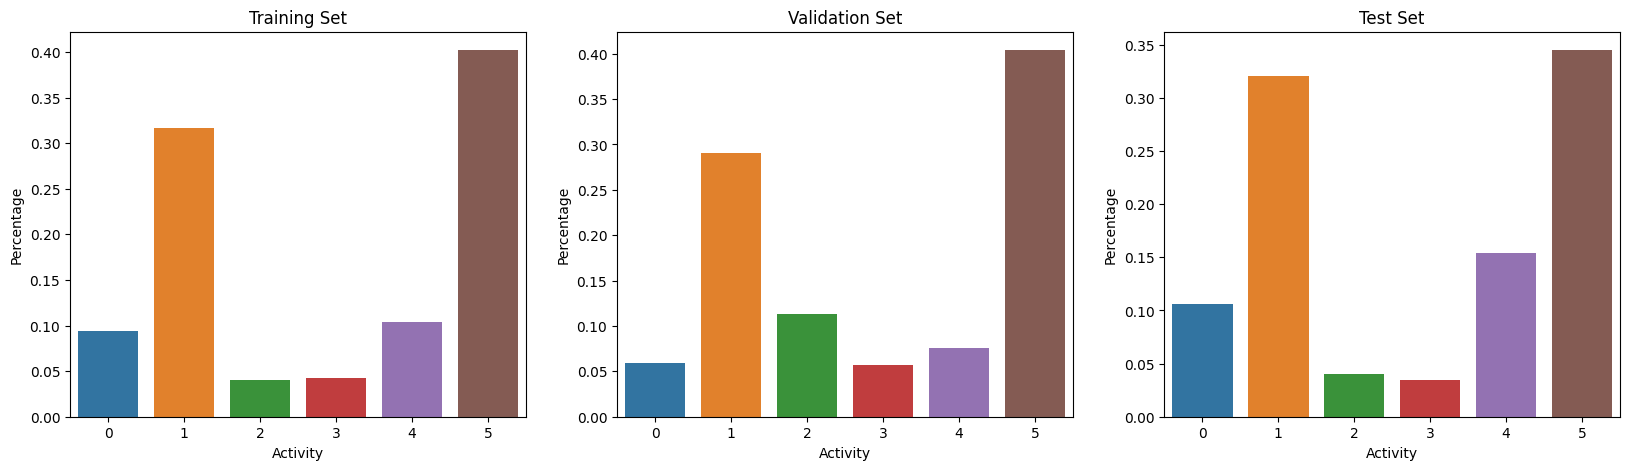

In [20]:
# plot the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

train_target = pd.Series(y_train).value_counts(normalize=True)
val_target = pd.Series(y_val).value_counts(normalize=True)
test_target = pd.Series(y_test).value_counts(normalize=True)

sns.barplot(x=train_target.index, y=train_target.values, ax=ax[0])
ax[0].set_title('Training Set')
ax[0].set_xlabel('Activity')
ax[0].set_ylabel('Percentage')

sns.barplot(x=val_target.index, y=val_target.values, ax=ax[1])
ax[1].set_title('Validation Set')
ax[1].set_xlabel('Activity')
ax[1].set_ylabel('Percentage')

sns.barplot(x=test_target.index, y=test_target.values, ax=ax[2])
ax[2].set_title('Test Set')
ax[2].set_xlabel('Activity')
ax[2].set_ylabel('Percentage')